# **Adding data to the Geoanalytics STAC server**

In [1]:
# We will be using Sentinel-2 L2A imagery from Microsoft Planetary Computer's STAC server:
!pip install planetary_computer
!pip install boto3
!pip install rasterio
!pip install shapely
!pip install geojson

In [2]:
import io
import os
import sys
import time
import boto3
import shapely
import pickle
import getpass
import requests
import datetime
import json
import geojson
import glob
import dask
import rasterio
import gcsfs
import pystac
import stackstac
import planetary_computer

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt 

from json import JSONEncoder
from rasterio.warp import calculate_default_transform
from pathlib import Path
from dask.distributed import performance_report
from shapely.geometry import Polygon, mapping, shape
from shapely.ops import unary_union
from datetime import datetime
from itertools import islice
from pystac.extensions.projection import ProjectionExtension
from pystac.extensions.eo import Band
from pystac_client import Client
from dask_gateway import Gateway
from IPython.display import clear_output
from shapely import wkt
from shapely.geometry import box
from dateutil.parser import parse as dateparse
from urllib.request import urlopen, Request, build_opener, HTTPCookieProcessor
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from IPython.display import clear_output
from typing import Any, Dict, List, Optional, cast

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
gateway = Gateway()

# Cluster configuration 
options = gateway.cluster_options()
options.image = 'pangeo/pangeo-notebook:2022.04.15' ## need to update this to be automated

In [5]:
cluster = gateway.new_cluster(options)
cluster

In [6]:
# Scale the cluster
workers = 10
cluster.scale(workers) 

In [7]:
# Assign client to this cluster so Dask knows to use it for computations
client = cluster.get_client() 

In [8]:
client.wait_for_workers(workers-1)
cluster

In [9]:
gateway.list_clusters()

[ClusterReport<name=pangeo.67d42d0d9b9749aa9435ce24c637683d, status=RUNNING>]

#### Remember to register for the gcsfs client, in order to access the Google Cloud Storage Buckets

In [16]:
def register_gcsfs_client(username:str):
    # set up the gcsfs system with credentials
    print('registering gcsfs')
    tok = os.path.join(os.environ['HOME'], f'geoanalytics_{username}', 'geo.json') # Change this to your own cred file
    tok_dict = json.load(open(tok))
    gcs = gcsfs.GCSFileSystem(token=tok_dict, access='read_write')
    return gcs

In [ ]:
username = input('Username:')
gcs = register_gcsfs_client(username=username)

## 1. Query the Sentinel 2 Data from PlanetaryComputer

In this section we will query Planetary Computer's STAC API as we have done in the past. However, we will add the additional step of downloading this data into our GeoAnalytics Google Cloud Storage bucket. This will enable us to host the data on our own STAC server. Making it easy for us to query and use.

In [10]:
# Create a polygon for defining our Area of Interest (AOI) in this case we are using a rough outline of Quebec City,Quebec created using: https://www.keene.edu/campus/maps/tool/
polygon ={
  "coordinates": [
    [
      [
        -71.5577316,
        46.9574391
      ],
      [
        -71.5588903,
        46.9381912
      ],
      [
        -71.5264034,
        46.9373414
      ],
      [
        -71.5258884,
        46.9588158
      ],
      [
        -71.5577316,
        46.9574391
      ]
    ]
  ],
  "type": "Polygon"
}

In [11]:
lon_list = []
lat_list = []

for lon,lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

,geometry
0,"POLYGON ((-71.55773 46.95744, -71.55889 46.938..."


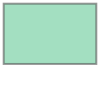

In [12]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [13]:
bounds = FOOTPRINT.bounds

#### The write_ras function will take an XArray.DataArray, convert it into a Cloud Optimized GeoTIFF (COG) and save it to a path of our choice.

In [15]:
# Function to write from the dask cluster to the remote bucket
@dask.delayed
def write_ras(gcs, epsg, ras, b, pth):
    import rioxarray
    try:
        ds = xr.Dataset()
        ras = ras.rio.write_crs(epsg)
        ras.rio.to_raster('ras.tif')
        # Turn the raster into a COG
        dst_profile = cog_profiles.get("deflate")
        cog_translate(
            'ras.tif',
            'ras_cog.tif',
            dst_profile,
            in_memory=True,
            quiet=False,
        )
        # Use GCSFS Client to put COG into remote bucket
        gcs.put('ras_cog.tif', pth)
        # Clean up rasters on Dask Worker
        os.remove('ras.tif')
        os.remove('ras_cog.tif')
        return 'success'
    except Exception as e:
        # Return error and associated band
        return f'{b}: {e}'

In [17]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

<Client id=microsoft-pc>

In [104]:
save_path = "/home/jovyan/geoanalytics_user_shared_data/Tutorial_stac_test"
local_path = f'/home/jovyan/geoanalytics_user_shared_data/Tutorial_stac_test'
Type = "COG"
epsg = 32618

In [19]:
# CONFIG 
# -------------
BASE_PTH = 'gs://geoanalytics-user-shared-data'
OUTPUT_DIR = 'Tutorial_stac_test'
TGT_BANDS =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
YEARS = ['2019','2020']
BEGIN_MONTH = '06'
END_MONTH = '09'
MAX_CLOUD = 100
READ_IN_CHUNK = 4096
RESOLUTION = 10
TEMPORAL_CHUNK = {'time': -1, 'band': 1, 'x': 128, 'y': 128}
SYNCHRONOUS = True # Write bands out one at a time - use if resources can't handle all bands at once for AOI
# -------------

In [ ]:
catalog = pystac.Collection(id='S2-test-catalog', description='Tutorial catalog of Sentinel 2 imagery around Quebec City')

#### The following loop queries the Planetary Computer STAC API, uses STACstack to convert the output into an XArray.DataArray and then saves it to our GCS bucket.

In [139]:
# Download the data
item_dict = []
raster_list = []
json_list = []
for year in YEARS:
    OUT_PTH = f'{BASE_PTH}/{OUTPUT_DIR}/{year}'
    date_range = f'{year}-{BEGIN_MONTH}-01/{year}-{END_MONTH}-30'
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {year}')
    items = api.search(
        collections = ['sentinel-2-l2a'],
        intersects = FOOTPRINT,
        query={"eo:cloud_cover": {"lt": MAX_CLOUD}}, #"s2:mgrs_tile":{"eq":'10UFA'}},
        datetime = date_range,
    ).get_all_items()
    
   
    print(f'\tFound {len(items)} items')
    # # planetarycomputer requires signed URLs to access Asset HREFs. 
    print('\t[Signing data links]')
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    item_dict+=signed_items
    # print(item_dict)
    #     # Iterate over bands and build composite DAG
    for item in item_dict:
    #     #clear_output(wait=True) # clear Jupyter Cell output
        print('\t[Converting STAC query to DataArray]')
        data = (
            stackstac.stack(
                item,
                assets=TGT_BANDS, 
                chunksize=READ_IN_CHUNK, # Set chunksize
                resolution=RESOLUTION, # Set all bands res to this
                bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
                epsg = 32618
            ).where(lambda x: x > 0, other=np.nan).assign_coords( # Convert nodata zero to np.nan
                #band=lambda x: x.common_name.rename("band"),  # use common names
                time=lambda x: x.time.dt.round(
                    "D"
                ))  
        )
        
        image_name = item['id']
        
        print(f'Saving {image_name} metadata')
        
        with open(f'{save_path}/{year}/{image_name}.json', 'w') as fp:
                    json.dump(item, fp, indent=4)
            
        gcs.put(f'{local_path}/{year}/{image_name}.json', f'{OUT_PTH}/{image_name}.json')
        
        print(f'Appending {image_name} metadata and rasters to lists')
        
        json_list.append(item)
        
        raster_list.append(write_ras(gcs, epsg, data.squeeze(), image_name, f'{OUT_PTH}/{image_name}.tif'))
        
        clear_output(wait=True)
              
print(f'Downloading the rasters')
              
with performance_report('dask_report.html'):
    print(dask.compute(raster_list)[0])        

['success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success'

## 2. Create STAC Items for each downloaded image

Next we create STAC Items, containing all relevant Metadata, for each downloaded image and add them to a STAC Collection.

The create_STAC_Item function, takes the path of our COGs, and their Metadata, and creates STAC items with the correct metadata for each Image we have downloaded. The parameters to instantiate each PySTAC item will be:

- ID: the ID of each image.
- Geometry: The geojson polygon feature of the image.
- Bounding Box: The boundaries of our image.
- Datetime: The Acquisition Time of the image.
- Properties: Sentinel 2 specific metadata.
- Projection: The original projection of the imagery.
- Asset: The filepath of our data.

If you wish to learn more about STAC Items follow this link to the STAC Item specification: https://github.com/radiantearth/stac-spec/tree/master/item-spec

In [52]:
@dask.delayed
def create_STAC_Item(tiff_path, metadata_json,gcs):
    
    with rasterio.open(tiff_path) as sample_cog:
     #   left, bottom, right, top = sample_cog.bounds
        bounds = sample_cog.bounds
        src_crs = sample_cog.crs
        dst_crs = 'EPSG:4326'  # EPSG identifier for WGS84 coordinate system used by the geojson format
        left, bottom, right, top = rasterio.warp.transform_bounds(sample_cog.crs, dst_crs, *bounds)
        bbox = [left, bottom, right, top]
        
        # Create geojson feature
        geom = mapping(Polygon([
          [left, bottom],
           [left, top],
           [right, top],
           [right, bottom]
        ]))
        time_acquired = datetime.strptime((metadata_json['properties']['datetime']), '%Y-%m-%dT%H:%M:%S.%fZ')
        
        # Instantiate pystac item
        item = pystac.Item(id=metadata_json["id"][:-4],
                           geometry=geom,
                           bbox=bbox,
                           datetime = time_acquired, 
                           properties={})
    
        # Use Planet metadata.json to add some Sentinel specific metadata to the STAC item
        cols = ['platform','proj:epsg','instruments','s2:mgrs_tile','constellation','s2:granule_id',
        'eo:cloud_cover','s2:datatake_id','s2:product_uri','s2:datastrip_id','s2:product_type','sat:orbit_state','s2:datatake_type','s2:generation_time',
               'sat:relative_orbit','s2:water_percentage','s2:mean_solar_zenith','s2:mean_solar_azimuth','s2:processing_baseline','s2:snow_ice_percentage',
                's2:vegetation_percentage','s2:thin_cirrus_percentage','s2:cloud_shadow_percentage','s2:nodata_pixel_percentage','s2:unclassified_percentage',
               's2:dark_features_percentage','s2:not_vegetated_percentage','s2:degraded_msi_data_percentage','s2:high_proba_clouds_percentage',
               's2:reflectance_conversion_factor','s2:medium_proba_clouds_percentage','s2:saturated_defective_pixel_percentage']
        for prop in cols:
            item.properties[prop] = metadata_json['properties'][prop]
            
        item.properties['original_links'] = metadata_json['links'][0]
    
        # Enable item extensions
        projection = ProjectionExtension.ext(item, add_if_missing=True)
        projection.epsg = 'EPSG:32618'
        
        # Add the link to the asset (the path to the geotiff)
        item.add_asset(key='analytic', asset=pystac.Asset(href=cog,
                                                          title= "13 Bands MODIS MCD12Q1 Raster", # indicate it is a cloud optimized geotiff
                                                          media_type=pystac.MediaType.COG,
                                                          roles=(["analytic"]))) 
    
     
        # Tuple containing spatial and temporal extent information to use later in this tutorial
        item_extent_info =  (bbox, geom, time_acquired)
     
    # Returns a list containing the PySTAC Item object and a tuple holding the bounding box, geojson polygon, and date the item was acquired
    return (item, (item_extent_info))

In [112]:
%%time
stac_items_list = []
for year in YEARS:
    print(year)
    imagelist = gcs.glob(f'geoanalytics-user-shared-data/Tutorial_stac_test/{year}/[!S]*')
    for image in imagelist:
        # print(image)
        if image.endswith(".json"):
            print(image)
            cog = f'{image[:-5]}.tif'
            with gcs.open(f'gs://{image}') as f:
                metadata_json = json.load(f)
                stac_items_list.append(create_STAC_Item(f'gs://{cog}', metadata_json, gcs))
            
clear_output(wait=True)

print(f'Computing stac_items_list')
with performance_report('dask_report.html'):
    print(dask.compute(stac_items_list)[0])

Computing stac_items_list
[(<Item id=S2A_MSIL2A_20190602T153911_R011_T18TYT_20201005T21>, ([-71.56036362269732, 46.93638627772491, -71.52454981552867, 46.95988141775976], {'type': 'Polygon', 'coordinates': (((-71.56036362269732, 46.93638627772491), (-71.56036362269732, 46.95988141775976), (-71.52454981552867, 46.95988141775976), (-71.52454981552867, 46.93638627772491), (-71.56036362269732, 46.93638627772491)),)}, datetime.datetime(2019, 6, 2, 15, 39, 11, 24000))), (<Item id=S2A_MSIL2A_20190602T153911_R011_T19TCN_20201005T21>, ([-71.56036362269732, 46.93638627772491, -71.52454981552867, 46.95988141775976], {'type': 'Polygon', 'coordinates': (((-71.56036362269732, 46.93638627772491), (-71.56036362269732, 46.95988141775976), (-71.52454981552867, 46.95988141775976), (-71.52454981552867, 46.93638627772491), (-71.56036362269732, 46.93638627772491)),)}, datetime.datetime(2019, 6, 2, 15, 39, 11, 24000))), (<Item id=S2A_MSIL2A_20190605T154911_R054_T18TYT_20201005T22>, ([-71.56036362269732, 46.9

The following cell creates a couple functions that will help us visualize the footprint of our items. In this case all our items have the same footprint because we cut the images to a specific geometry in the download step. However, if you did not do that or if you were working in a larger area, these functions would help you visualize the area each image covers.

In [113]:
# Next step is create a STAC Collection to hold all the Items. 
# Take a look at the STAC Collection Spec (https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md) to understand the requirements for initializing a collection. 
# The parameters to Instantiate the PySTAC Collection will be:
# ID: this will be in the format of where the data comes from, where it is stored, and the satellite and sensor name.
# Title: The general title of the Sensor.Description: Some details of the products contained within the collection.
# (basic metadata)Extent: The spatial and temporal extents of the entire collection.
# Summaries: Containing the band information from the Summary dictionary saved above (needs to be converted to a PySTAC Summary).
# Keywords: List of keywords describing the Collection.
# License: Collection's license(s) (proprietary as default)

#The functions below are to calculate the full extent (spatial and temporal) of all the items.

# @dask.delayed
def create_full_extent(stac_item_list):
    polygons = []
    datetimes = []
    
    for index, stac_item in enumerate(stac_item_list):
        geometry = stac_item[1][1]
        polygons.append(shape(geometry))
        datetime = stac_item[1][2]
        datetimes.append(datetime)
        
    # Get the spatial extent
    spatial_extent = get_spatial_extent(polygons)
    
    # Get temporal extent
    temporal_extent = get_temporal_extent(min(datetimes), max(datetimes))
    collection_extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)
    
    return collection_extent


def get_spatial_extent(polygons):
    # Plot of polygons overlay
    plt.figure(figsize=(14, 8))
    for polygon in polygons:
        plt.plot(*shape(polygon).exterior.xy)

    # Returns a union of the two geojson polygons for each item
    unioned_geometry = unary_union(polygons)

    # Plot the unified polygon
    x, y = shape(unioned_geometry).exterior.xy
    plt.figure(figsize=(14,8))
    plt.fill(x, y, alpha=0.5, facecolor='none', edgecolor='purple', linewidth=7)
    plt.show()
    
    # Set the bbox to be the bounds of the unified polygon and return the spatial extent of the collection
    return pystac.SpatialExtent(bboxes=[unioned_geometry.bounds])


def get_temporal_extent(startime, endtime):
    time_interval = [startime, endtime]
    temporal_extent = pystac.TemporalExtent(intervals=[time_interval])
    return temporal_extent

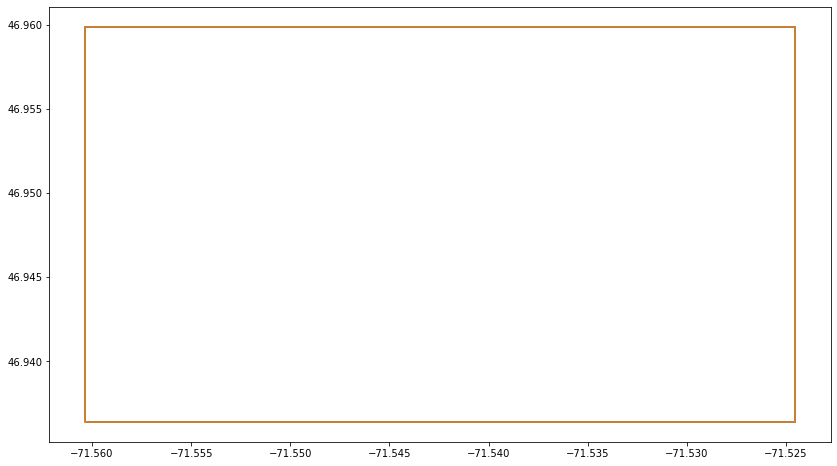

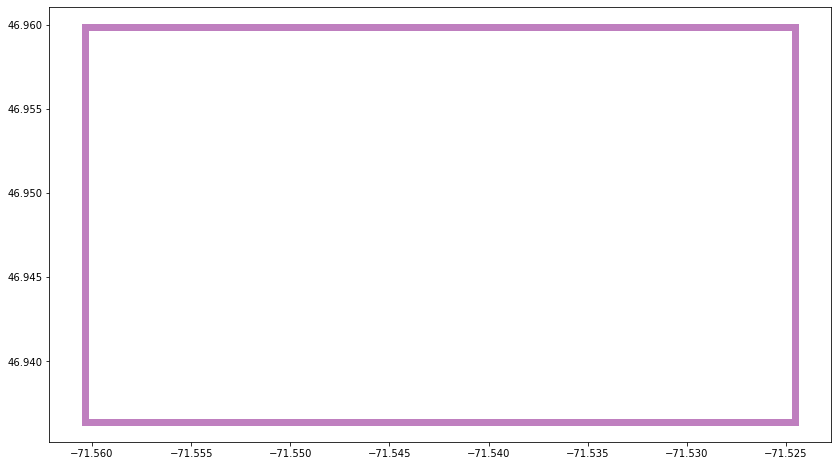

In [87]:
extent = create_full_extent(dask.compute(stac_items_list)[0])

# dask.compute(extent)

## 3. Create a STAC Collection to which append our STAC items 

Once we have our individual STAC items, we require somewhere to append them. To create a STAC collection we'll use the following parameters:

- ID: What we wish to call our collection.
- Title: Collection's title.
- Description: Details regarding the items within the collection.
- Keywords: List of keywords describing the collection.
- Licence: Collection's license(s). (Set proprietary as the default)

If you wish to read up on STAC Collections follow this link: https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md


In [120]:
# Here is where we create the Collection, passing in the calculated extent and the band summary as parameters. If you want to add to a collection leave id unchanged and run as is.
# If you want to create a collection change ID here and in the item posting section.

collection = pystac.Collection(id='geoanalytics.googlecloud.quebec_city.S2L2a.TEST',
                               title='Sentinel 2: Level 2a Test for Quebec City over the years of 2019 and 2020',
                               description="Sentinel 2: Level 2a imagery covering Quebec City for the years of 2019 and 2020. Provides imagery of 10, 20, and 60m resolution (band dependent).",
                               extent=extent,
                               keywords=['sentinel2', 'msi','esa'],
                               license='proprietary',)


In [121]:
collection.describe()

* <Collection id=geoanalytics.googlecloud.quebec_city.S2L2a.TEST>


In [122]:
collection.to_dict()

{'type': 'Collection',
 'id': 'geoanalytics.googlecloud.quebec_city.S2L2a.TEST',
 'stac_version': '1.0.0',
 'description': 'Sentinel 2: Level 2a imagery covering Quebec City for the years of 2019 and 2020. Provides imagery of 10, 20, and 60m resolution (band dependent).',
 'links': [{'rel': <RelType.ROOT: 'root'>,
   'href': None,
   'type': <MediaType.JSON: 'application/json'>,
   'title': 'Sentinel 2: Level 2a Test for Quebec City over the years of 2019 and 2020'}],
 'stac_extensions': [],
 'title': 'Sentinel 2: Level 2a Test for Quebec City over the years of 2019 and 2020',
 'extent': {'spatial': {'bbox': [(-71.56036362269732,
     46.93638627772491,
     -71.52454981552867,
     46.95988141775976)]},
  'temporal': {'interval': [['2019-06-02T15:39:11.024000Z',
     '2020-09-29T15:39:49.024000Z']]}},
 'license': 'proprietary',
 'keywords': ['sentinel2', 'msi', 'esa']}

In [123]:
# Once we have our STAC Items, we need to add them to a Collection. Let's enumerate over the list of stac items and using the PySTAC method, .add_item() to add to the collection.

# add items to the collection
for index, item in enumerate(dask.compute(stac_items_list)[0]):
    print(index)
 #   data = json.dumps(stac_item[0].to_dict())
    #print(item)
    collection.add_item(item[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


In [124]:
collection.describe()

* <Collection id=geoanalytics.googlecloud.quebec_city.S2L2a.TEST>
  * <Item id=S2A_MSIL2A_20190602T153911_R011_T18TYT_20201005T21>
  * <Item id=S2A_MSIL2A_20190602T153911_R011_T19TCN_20201005T21>
  * <Item id=S2A_MSIL2A_20190605T154911_R054_T18TYT_20201005T22>
  * <Item id=S2A_MSIL2A_20190605T154911_R054_T19TCN_20201005T22>
  * <Item id=S2A_MSIL2A_20190612T153911_R011_T18TYT_20201006T01>
  * <Item id=S2A_MSIL2A_20190612T153911_R011_T19TCN_20201006T01>
  * <Item id=S2A_MSIL2A_20190615T154911_R054_T18TYT_20201006T02>
  * <Item id=S2A_MSIL2A_20190615T154911_R054_T19TCN_20201006T02>
  * <Item id=S2A_MSIL2A_20190625T154911_R054_T19TCN_20201006T06>
  * <Item id=S2A_MSIL2A_20190702T153911_R011_T18TYT_20201005T08>
  * <Item id=S2A_MSIL2A_20190702T153911_R011_T19TCN_20201005T08>
  * <Item id=S2A_MSIL2A_20190705T154911_R054_T18TYT_20201005T09>
  * <Item id=S2A_MSIL2A_20190705T154911_R054_T19TCN_20201005T09>
  * <Item id=S2A_MSIL2A_20190712T153911_R011_T18TYT_20201005T12>
  * <Item id=S2A_MSIL2A_

## 4. Add our completed collection to the GeoAnalytics STAC Server

To add our collection to the GeoAnalytics STAC server all we'll need is our GeoAnalytics Authorization Token, the collection URL for GeoAnalytics, and our local collection.

- First upload the structure of the Collection itself. 
- Second upload the individual STAC Item to the collection in GeoAnalytics.

In [125]:
# Add Items and Collection to STAC Server

auth_token = input("Please copy and paste your API Access Token here: ").strip()

Please copy and paste your API Access Token here:   _oauth2_proxy=eyJBY2Nlc3NUb2tlbiI6IjV2MHo4bWwwYnFIdi9pNTloZGhHVE1ObVo5Vis0NmFqVHV4VXQ1NUlubVY4UEdvcjI3aTJibnpyc0wydFNkTCtVaWtFWGUwbkRWVFRnR0x5dUhJZUJPV2ZOSHpwcGRPd09mQVZlTEdNNkVVVi9PN2RFOUFSOWRVcE1DWEpVbUk3TVR2dDRFdGd1Si91VSszT2lsblVkUVBHRmFlV3dMUW9zTkozYi81VXdsT2czSXdKcGIrS1BIRzNuR2xkQytOTlJBa3pycW1udlBFdGcyR21tZ01uUDgzQVZOL0NyUXZaUEVlMGRiNktzLzh0R1NEdnVnTWVlSE9kbUxubXFrbzZDajVrZGtTODkyTUZ5OUlSUlNIVkJTdUF3OVU2blFKOW9EU3JtdDR1emhOM1owU25qY0tGeDF0MzlCYm1odmlGWU1ITmxTeVIyU0g4TkxVSnNCbGlHaVRQaXpZOW5HWUpWeGFSNkM2a3plcXZjL3ZmRVRMMkhjY0xjeTlXQkVvRWJMb1NZalZ1ZXlyYzM1VzdwNlh6SnJkN05pbExzdmY4VnlkbkdJK0UwYW1DV1J2eHl3bVhlVTFMS1UyYWRCQzJXUkFzWVRKS0c5MVYyNFlyRkZXSG5lQmlUV2NkQVE0TTR6V2NkMmtqQlBBUWVWWVVJRkxWNitBU3oxaUIrWnAvY3p5ZENROEJxU1Nvd2tId0FuMHZMZjVzazlmL09hTjJjRjZzMDZ2cXFFVy83ckdxRnRDMVRQRmNjaDlwaGhBVUh6SnBaOURrRkhmdHNrNm5pRzBZYnZaelE1dHpGNTg0aTdLTzBXcTNUVlBMcFVFWnZibHo3bUV3dmFja0xvOVl0c2VRb2N0Z0JmV0xLWmkvbEtHNlVRR1ZkMFBOekJYNTdrVVFYdHJ1bmJCa0

In [126]:
# To add to the STAC, we use the requests.post() method to add, and the requests.pull() method to make updates to existing items.
# Now, let's add the collection to the STAC Server's collection page by passing the API token in the header and the JSON of the collection as data.

headers={'cookie': auth_token}
data = json.dumps(collection.to_dict())
r = requests.post('https://stac.geoanalytics.ca/collections', data=data, headers=headers)

In [127]:
print(r)

<Response [200]>


In [128]:
%%time
headers={'cookie': auth_token}
for index, stac_item in enumerate(dask.compute(stac_items_list)[0]):
    print(stac_item)
    data2 = json.dumps(stac_item[0].to_dict())
    r = requests.post('https://stac.geoanalytics.ca/collections/geoanalytics.googlecloud.quebec_city.S2L2a.TEST/items', data=data2, headers=headers)

(<Item id=S2A_MSIL2A_20190602T153911_R011_T18TYT_20201005T21>, ([-71.56036362269732, 46.93638627772491, -71.52454981552867, 46.95988141775976], {'type': 'Polygon', 'coordinates': (((-71.56036362269732, 46.93638627772491), (-71.56036362269732, 46.95988141775976), (-71.52454981552867, 46.95988141775976), (-71.52454981552867, 46.93638627772491), (-71.56036362269732, 46.93638627772491)),)}, datetime.datetime(2019, 6, 2, 15, 39, 11, 24000)))
(<Item id=S2A_MSIL2A_20190602T153911_R011_T19TCN_20201005T21>, ([-71.56036362269732, 46.93638627772491, -71.52454981552867, 46.95988141775976], {'type': 'Polygon', 'coordinates': (((-71.56036362269732, 46.93638627772491), (-71.56036362269732, 46.95988141775976), (-71.52454981552867, 46.95988141775976), (-71.52454981552867, 46.93638627772491), (-71.56036362269732, 46.93638627772491)),)}, datetime.datetime(2019, 6, 2, 15, 39, 11, 24000)))
(<Item id=S2A_MSIL2A_20190605T154911_R054_T18TYT_20201005T22>, ([-71.56036362269732, 46.93638627772491, -71.5245498155

##### Now you know how to find data in a free STAC API, download it, and add it to your own STAC API for internal use. 

##### Don't forget to shutdown your clusters and close your client!

In [129]:
cluster.shutdown()
client.close()